Z = 75559.75688825031
y = 19.0
optimal number of watts to install is: 5985.0 W
Total Capitial Cost: $19258.0


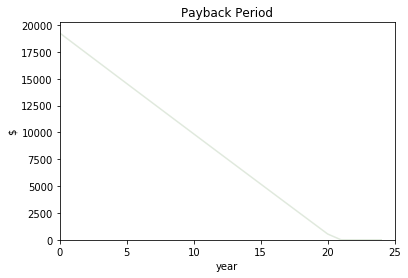

In [4]:
# installing and importing mip
# !pip install --user mip
from mip import *
import math
import matplotlib.pyplot as plt
import numpy as np

# defining parameters
E0 = 9000000  # yearly electricity usage (W) from user
E = [E0]  # yearly electricity usage (W) with trend
Cg = 0.0004944057773  # cost of electricity from the grid ($/W)
m = 10  # yearly maintenance cost ($/panel)
B = 20000  # budget from user
Cp = 315*2.80  # cost of each solar panel ($/panel) (12 modules of 60cell)
Ap = 18.9  # area of solar panel (ft^2) (40 * 68 inches)
Ar = 2000  # area of the roof (ft^2) from user
Armax = (Ar / 2) * 0.8
P = 315  # capacity of each solar panel (W) per year
F = 2500  # fixed costs of installing solar panels
d = []  # deterioration factor at year i (%)
U = 0.98  # how much energy can be used (%) (factors: irradiation, shadow, direction)
I = 25  # lifespan of solar panels
Pb = 13500  # battery capacity from user (W)
D = 1  # depth of discharge for battery system (%)

# filling in depreciation values (currently set to 0.07%)
for i in range(I):
    d.append(0.0007 * i)

# function to fill in Et - linearly decreases by 1.4%
for i in range(1, I):
    E.append(E[i - 1] - (E[i - 1] * 0.014))

# filling in cost of electricity and converting to present value Cgt - TODO

# actually calculate U properly
# define variables
soiling = 0.02  # loses due to dirt/dust on panels (higher for high pollution, low rainfall areas)
shading = 0.03  # might change to be an input from users
snow = 0  # assume that homeowner will clear snow from panels
mismatch = 0.02  # electrical losses due to manufacturing
wiring = 0.02  # loss between DC and AC conversion
connections = 0.005  # loss between electrical connectors
nameplaterating = 0.01
availability = 0.03

U = (1 - soiling) * (1 - shading) * (1 - snow) * (1 - mismatch) * (1 - wiring) * (1 - connections) * (
        1 - nameplaterating) * (1 - availability)

# convert m into present value - TODO
# FV = PV * ((1 + (i/n))^(n*t))

# using E @ t=0
Pn = math.ceil(
    (E0 / 365) / (P * U))  # number of solar panels needed to fulfill at least 100% of electricity from the grid

# calculating frequency of re-charging the battery R - TODO
Ehourly = (E0/365)/24 # hourly demand from user
o = 4.78 # avg. number of outages per year in Ontario
h = 2.79 # avg. number of hours per outage in Ontario
R = math.ceil((o*h*Ehourly)/(B*D))

# initializing model
model = Model()

# initializing decision variable
y = model.add_var(name='y', var_type=INTEGER)  # number of solar panels

# initializing the objective function
model.objective = minimize(xsum((E[i] - ((y * P * U * 365) * (1 - d[i])) - (R*B*D)) * Cg + (m * y) for i in range(I)))

# adding constraints
model += (y * Cp) + F <= B  # budget constraint
model += y * Ap <= Armax  # area of roof constraint **NEED TO ADD FACTOR TO CALCULATE USABLE ROOF SIZE**
model += Pn - y >= 0  # fulfill demand constraint
model += y >= 0  # non-negativity constraint

# solving the MIP
status = model.optimize()

# printing solution
if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
    print("Z = {}".format(model.objective_value))
    print("y = {}".format(y.x))  # printing decision variable value
    numWatts = y.x * P
    numPanels = y.x
    print("optimal number of watts to install is: " + str(numWatts) + " W")
    if numPanels > 0:
        totalCost = (numPanels * Cp) + F
    else:
        totalCost = 0
    print("Total Capitial Cost: $" + str(totalCost))
if status == OptimizationStatus.NO_SOLUTION_FOUND:
    print("no feasible solution :(")

# yearly grid energy cost w/o solar vs. yearly grid energy cost w/ solar (grouped bar chart)
# set width of bar
barWidth = 0.40

# set height of each bar
costsWithoutSolar = []
for i in range(i + 1):
    costsWithoutSolar.append(E[i] * Cg)  # will need to change to Cgt
# print(costsWithoutSolar)

costsWithSolar = []
for i in range(i + 1):
    costsWithSolar.append(max(0, (E[i] - (numPanels * P * U * 365 * (1 - d[i]))) * Cg))  # will need to change to Cgt
# print(costsWithSolar)

# set position of bar on X axis
r1 = np.arange(len(costsWithoutSolar))
r2 = [x + barWidth for x in r1]

# make the plot
# plt.bar(r1, costsWithoutSolar, color='#e0e9ddff', width=barWidth, edgecolor='white', label='Cost without solar')
# plt.bar(r2, costsWithSolar, color='#ffe599ff', width=barWidth, edgecolor='white', label='Cost with solar')

# plt.legend()
# plt.show()


# payback period (line graph)
year = []
for i in range(I):
    year.append(i)

savings = []
for i in range(I):
    savings.append(costsWithoutSolar[i] - costsWithSolar[i])
#print(savings)

yoySavings = [totalCost]
for i in range(1, I):
    yoySavings.append(max(0, yoySavings[i - 1] - savings[i - 1]))
#print(yoySavings)

plt.xlim(0, 25)
plt.ylim(0, totalCost + 1000)
plt.xlabel('year')
plt.ylabel('$')
plt.title('Payback Period')
plt.plot(year, yoySavings, color='#e0e9ddff')
plt.show()
